In [126]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from pathlib import Path
from frlearn.classifiers import FRNN
from sklearn.model_selection import train_test_split
from frlearn.base import probabilities_from_scores
from sklearn.metrics import roc_auc_score
import tqdm,time
from tqdm import tqdm


index = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","win"]


data = pd.read_csv('/home/hamid/hamash_amir/research/rough_set/kr-vs-kp_csv.csv')
data.rename(columns = {'class':"win"}, inplace=True)

ns = pd.get_dummies(data[data.columns[:-1]], prefix=data.columns[:-1],drop_first=True, dtype=int)

ns_y = data['win'].copy()
Y = pd.get_dummies(ns_y,prefix='win',drop_first=True, dtype=int)


class Colony:
    


    dataframe: object = ns
    pheromone = np.ones((ns.shape[1], ns.shape[1]))
    traversed_nodes = np.zeros((ns.shape[1],ns.shape[1]))
    ant_route: list[int] = []
    alpha: int = 0
    beta: int = 0
    feature_choices: list[str] = dataframe.columns.tolist()
    feature1: str
    log: list[str] = []
    fg: list[str] = feature_choices.copy()
    acc_criteria: float
    rho: int | float
    delta = np.zeros((ns.shape[0],ns.shape[1]))
    colony_number: int = 0
    overall_ant_route: dict = {}
    
    # def __init__(self):
    #     self.ant_route = ant_route
    #     self.feature1 = feature1
    #     self.fg = fg
    
    
    @classmethod
    def set_stopping_criteria(cls, criteria):
        cls.acc_criteria = criteria
    
    @classmethod
    def set_rate_decay(cls, rate_decay):
        cls.rho = rate_decay
    
    @classmethod
    def add_generation(cls):
        cls.colony_number += 1

    
    @classmethod
    def get_log(cls):
        print(cls.log)
    
    @classmethod
    def reset_colony(cls):
        
        Colony.pheromone = np.ones((ns.shape[1], ns.shape[1]))
        Colony.traversed_nodes = np.zeros((ns.shape[1], ns.shape[1]))

        Colony.overall_ant_route.clear()
        Colony.log = []
        Colony.fg = cls.feature_choices.copy()
        
    @classmethod
    def initialization_alpha_beta(cls, alpha, beta):
        
        cls.alpha = alpha
        cls.beta = beta

    @classmethod
    def reset_ant_route(cls):
        cls.ant_route = []

    @classmethod
    def initialize_feature1(cls):
        ant_route = cls.ant_route
        if not ant_route:
            cls.feature1 = np.random.choice(cls.feature_choices)
        else:
            cls.feature1 = cls.feature_choices[cls.ant_route[-1]]
    
    
    @classmethod
    def ant(cls):

        cls.initialization_alpha_beta(0.5, 0.5)
        cls.initialize_feature1()
        feature1 = cls.feature1
        features = cls.dataframe.columns.tolist()
        if any(feature1 in x for x in cls.fg):
            cls.fg.remove(feature1)
        i = features.index(feature1)
        if i not in cls.ant_route:
            cls.ant_route.append(i)

        feat1_dist_prob = {}
        for feature2 in cls.fg:
           
            pij = cls.__probability_transition_rule(cls.feature1, feature2)
      
            j = features.index(feature2)
            feat1_dist_prob[j] = pij

        
            cls.log.append(f'{features.index(cls.feature1)}' 
                           f'--{features.index(feature2)}--{float(pij)}')

    
        ant_next_target_index = [key for key, value in feat1_dist_prob.items()\
            if value == max(feat1_dist_prob.values())][0]
        cls.traversed_nodes[i,ant_next_target_index] = 1
        # mitting criterion
        cls.ant_route.append(ant_next_target_index)
        fg_index = [key for key,value in feat1_dist_prob.items()]

    
    @classmethod
    def ants(
        cls, make_initialize: bool | None=None,
            number_of_ants_first_gen: int | None=None,
            number_of_ants_next_gen: int | None=None, 
            init_criteria: int | str | None=None,
            rate_decay: float | None=None, 
            phero_rate_decay: float | None=None):

        if cls.colony_number == 0 or make_initialize == True:
            cls.initialize_colony(
                number_of_ants_first_generation=number_of_ants_first_gen,
                                init_criteria=init_criteria)
            cls.generate_next_ants(
                number_of_ants_next_generation=number_of_ants_next_gen,
                rate_decay=rate_decay, phero_rate_decay=phero_rate_decay,
                criteria_func=cls.is_rough_set_criteria_met)
            

        
    @classmethod
    def change_pheromone(cls, q, rho):
        """
        After each generation of several ants or after each generation 
        it update pheromone matrix according to following formula:
         
        phromone[i,j](t+1) = (1-rho)*phromone[i,j](t) + Delta(ij)(t)
        
        rho is pheromone decay coefficient along time
        
        Delta(ij)(t) = |_| = Delta(ij)(t) = 
                       |_|   q/sigma(landa_prime(ant_route)/len(ant_route)) ,if traversed_node[i,j] = 1
                       |_| = 0                                            ,if traversed_node[i,j] = 0
        
        landa_prime is rough_set_measure           
        """
        cls.set_rate_decay = rho
        minimum_ant_route_len = np.min([len(x) for x in cls.overall_ant_route.values])
        for i in range(cls.delta.shape[0]):
            for j in range(cls.delta.shape[0]):
                if cls.traversed_nodes[i,j] == 1:
                    cls.delta[i,j] = q/minimum_ant_route_len
                    cls.pheromone[i,j] = (1 - cls.rho)*cls.pheromone[i,j] + cls.delta[i,j]
                elif cls.traversed_nodes[i,j] == 0:
                    cls.delta[i,j] = 0
                    cls.pheromone[i,j] = (1 - cls.rho)*cls.pheromone[i,j] + cls.delta[i,j]
        

    @classmethod
    def positive_region(cls):
        # assuming df is your DataFrame
        # assuming the last column is the decision column
        # partition dataframe based on decision classes
        df = cls.dataframe
        partitions = [group for _, group in df.groupby(df.iloc[:,-1])]
    
        # find positive region for each partition
        positive_regions = [group[group.duplicated(df.columns[:-1], keep=False)] for group in partitions]
    
        # return union of all positive regions
        return pd.concat(positive_regions)


    
    @classmethod
    def __probability_transition_rule(cls, feature1, feature2):
        col_index = ns.columns.tolist()
        i = col_index.index(feature1)
        j = col_index.index(feature2)
        l = col_index.copy()
        

        feat1 = feature1
        feat2 = feature2

        mic_ij = mutual_info_classif(ns[[feat1, feat2]], y=Y['win_won'], random_state=0)[1]
        phrmn_ij = cls.pheromone[i,j]
        init = 0
        for k in range(0,len(l)):
            if k != l.index(feature2):
                phrmn_il = cls.pheromone[i,k]
                mic_il = cls.pheromone[i,k]
                init += (phrmn_il**cls.alpha) * (mic_il**cls.beta)
        pij = ((mic_ij**cls.beta) * (phrmn_ij**cls.alpha)) / init
        return pij

    @classmethod 
    def initialize_colony(cls, number_of_ants_first_generation, init_criteria):
        """
        ivar: init_criteria: how much steps an ant in initialization must have.
        first of all we run this method for initialize first generation of colony
        in this method we set manually number_of_ants_first_generation variable
        to a number As a CRITERIA just for initialize pheromone matrix.in next 
        generations we set rough set feature selection CRITERIA and when 
        selected features by each ant in a colony met this limit that ant stop
        exploration and next ant begins.
        CAUTIONS!: RUN THIS METHOD JUST ONE TIME IN EACH COLONY!
        """ 
        
        # cls.overal_ant_route = {}
        
        j = 0
        while j < number_of_ants_first_generation:
            i = 0
            while i < init_criteria-1: 
                cls.ant()
                i += 1
            cls.overall_ant_route[j] = cls.ant_route
            print(cls.ant_route)
            cls.reset_ant_route()
            j += 1
        cls.add_generation()

    @classmethod
    def is_rough_set_criteria_met(cls, selected_feature: list[int]) -> bool:
        
        data = ns.iloc[:, selected_feature]
        X_train, X_test, y_train, y_test = train_test_split(data.values, Y.values.squeeze(), test_size=0.33, random_state=42)
        
        clf = FRNN()
        model = clf(X_train, y_train)


        scores = model(X_test)

        probabilities = probabilities_from_scores(scores)
        auroc = roc_auc_score(y_test, probabilities[:,-1])

        if auroc >= cls.acc_criteria:
            return True
        else:
            return False 
        
    @classmethod
    def is_landa_met(
        cls, selected_feature: list[int]) -> bool:
        """
        sim_threshold: similarity of each pair of instances that more than that
        these pairs trace as Similar together
        landa_criteria: stop one ant route exploration if met.  
        """
        
        landa_criteria = 0.7
        sim_threshold = 0.8
        # if selected_feature != []:
        X = ns.iloc[:, selected_feature].values
        y = Y.values.squeeze()
        R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), 
                         y[:, None, None] != y[:, None])
        # Define a threshold for the lower approximation
        

        # Calculate the differences between pairs of instances
        differences = []
        all = []
        for i in range(len(X)):
            for j in range(i+1, len(X)):
                difference = np.count_nonzero(R_a[i, j])
                similarity_percent = 1 - (difference/X.shape[1])
                if similarity_percent > sim_threshold and i != j:
                    differences.append(difference)
                all.append(difference)

        # Calculate the average difference
        criteria = len(differences) / ((X.shape[0]**2)/2)

        landa = criteria
        if landa >= landa_criteria:
            return True
        elif landa < landa_criteria or cls.ant_route == []:
            return False 

        
    @classmethod 
    def generate_next_ants(
        cls, number_of_ants_next_generation: int,
        rate_decay,
        phero_rate_decay
        # ,criteria_func
        ):
        
        try:
            if cls.colony_number > 0:
                j = 0
                while j < number_of_ants_next_generation:
                    i = 0
                    while not cls.is_landa_met(cls.ant_route) or (cls.ant_route == [] and cls.colony_number == 0):
                    # while True:  
                    # for j in range(number_of_ants_first_generation):
                        cls.ant()
                        # if cls.is_landa_met(cls.ant_route):
                        #     break
                        i += 1
                    cls.overall_ant_route[f'g{j}'] = cls.ant_route
                    print(cls.ant_route)
                    j += 1
                    cls.reset_ant_route()
                cls.change_pheromone(q=rate_decay, rho=phero_rate_decay)
            else:
                raise Exception("Colony generation doesnt initialized first!")
        except Exception as e:
            print(e)


In [115]:
Colony.ant_route

[]

In [111]:
Colony.ants(make_initialize=True,number_of_ants_first_gen=5,number_of_ants_next_gen=5,init_criteria=5,rate_decay=0.3,phero_rate_decay=0.2)

Found array with 0 feature(s) (shape=(1029, 0)) while a minimum of 1 is required by NearestNeighbors.


In [127]:
Colony.initialize_colony(number_of_ants_first_generation=5,init_criteria=5)

[13, 21, 9, 33, 32]
[20, 32, 7, 15, 36]
[28, 36, 29, 31, 16]
[35, 16, 18, 6, 23]
[23, 14, 1, 27, 22]


In [128]:
Colony.generate_next_ants(number_of_ants_next_generation=5,rate_decay=0.1,phero_rate_decay=0.3)

division by zero


In [125]:
Colony.overall_ant_route

{0: [15, 21, 9, 33, 32],
 1: [32, 7, 36, 29, 31],
 2: [17, 31, 16, 18, 6],
 3: [4, 6, 23, 14, 35],
 4: [1, 35, 27, 22, 5],
 'g0': [6, 5],
 'g1': [23, 5],
 'g2': [32, 5],
 'g3': [25, 5],
 'g4': [10, 5]}

In [6]:
from __future__ import annotations

from typing import Callable

import numpy as np

from frlearn.base import DataDescriptor, FeatureSelector, ClassSupervised
from frlearn.statistics.feature_preprocessors import Standardiser
from frlearn.array_functions import soft_min
from frlearn.t_norms import lukasiewicz_t_norm
from frlearn.uncategorised.quantifiers import QuadraticSigmoid
from frlearn.weights import QuantifierWeights
from frlearn.base import MultiClassClassifier
fr = MultiClassClassifier

In [8]:
index = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","win"]


data = pd.read_csv('/home/hamid/hamash_amir/research/rough_set/kr-vs-kp_csv.csv')
data.rename(columns = {'class':"win"}, inplace=True)

ns = pd.get_dummies(data[data.columns[:-1]], prefix=data.columns[:-1],drop_first=True, dtype=int)

ns_y = data['win'].copy()
Y = pd.get_dummies(ns_y,prefix='win',drop_first=True, dtype=int)

In [36]:
# X = ns.values
# y = Y.values.squeeze()
# # Calculate the fuzzy similarity relation
# R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), y[:, None, None] != y[:, None])

# # Define a threshold for the lower approximation
# threshold = 0.8

# # Calculate the lower approximations for each decision class
# lower_approximations = []
# for class_label in np.unique(y):
#     # Calculate the lower approximation for this class
#     lower_approximation = np.all(R_a[y == class_label] >= threshold, axis=0)
#     lower_approximations.append(lower_approximation)

# # Calculate the POS as the union of the lower approximations
# POS = np.any(lower_approximations, axis=0)

# # Calculate the size of the POS
# pos_size = np.sum(POS)
# landa = pos_size/ns.shape[0]

In [37]:
lower_approximations[1].shape

(3196, 37)

In [38]:
POS.shape

(3196, 37)

In [39]:
R_a.shape

(3196, 3196, 37)

In [46]:
pos_size

5603

In [40]:
landa = pos_size/ns.shape[0]
landa

1.7531289111389237

In [5]:
X = ns.values
y = Y.values.squeeze()
max = np.maximum(1 - np.abs(X[:, None, :] - X), 0)

In [6]:
max.shape

(3196, 3196, 37)

In [7]:
r = y[:, None, None] != y[:, None]
r.shape

(3196, 3196, 1)

In [15]:
R.shape

(3196, 3196)

In [19]:
X = ns.values
y = Y.values.squeeze()
co_Cs = [X[np.where(y != c)] for c in [0,1]]

0

In [94]:
import numpy as np
# def is_landa_met(cls) -> bool:
# Assume X is your dataset with shape (n_samples, n_features)
# and y is the corresponding target labels

# Calculate the fuzzy similarity relation
R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), y[:, None, None] != y[:, None])

# Define a threshold for the lower approximation
sim_threshold = 0.2

# Calculate the differences between pairs of instances
differences = []
all = []
for i in range(len(X)):
    for j in range(i+1, len(X)):
        difference = np.count_nonzero(R_a[i, j])
        similarity_percent = 1 - (difference/X.shape[1])
        if similarity_percent > sim_threshold and i != j:
            differences.append(difference)
        all.append(difference)

# Calculate the average difference
criteria = len(differences) / ((X.shape[0]**2)/2)

print(criteria)


0.8938136061816946


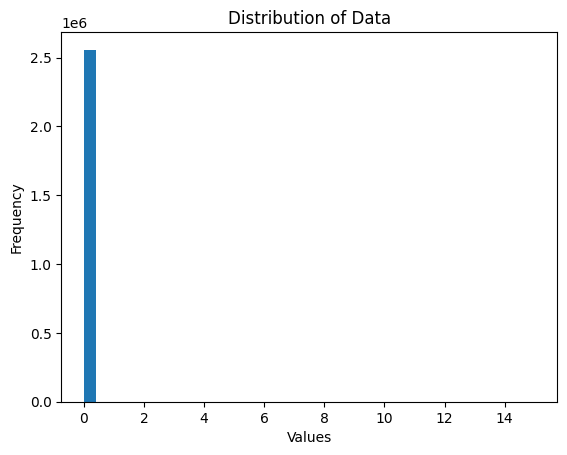

In [77]:
import matplotlib.pyplot as plt

# Example list of data
data = differences

# Plotting the histogram
plt.hist(data, bins=37)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.show()

In [91]:
len(differences)/((3196*3196)/2)

0.5006741452472662

In [92]:
len(differences) / ((X.shape[0]**2)/2)

0.5006741452472662

In [90]:
len(all)

5105610

In [88]:
(3196*3196)/2

5107208.0

In [27]:
Colon.make_change()

In [28]:
Colon.pherom

5

In [29]:
ant = Ant()
ant.multiple()
Colon.pherom

10